# Import Libraries/Dataset                                                             

In [0]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import to_date, year, month, dayofmonth
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor

In [0]:
# Create a SparkSession
spark = SparkSession.builder.appName("COVID-19 Dataset Analysis").getOrCreate()

In [0]:
# Download the dataset
df = spark.read.csv("/FileStore/tables/covid_dataset.csv", header=True, inferSchema=True)


# Data Visualization and Exploration                                                        

In [0]:
# Print at least 5 rows for sanity check
print(df.show(5))

+----------+-------+---------+---------+------+
|      Date|Country|Confirmed|Recovered|Deaths|
+----------+-------+---------+---------+------+
|2020-05-01|  India|    37257|    10007|  1223|
|2020-05-02|  India|    39699|    10819|  1323|
|2020-05-03|  India|    42505|    11775|  1391|
|2020-05-04|  India|    46437|    12847|  1566|
|2020-05-05|  India|    49400|    14142|  1693|
+----------+-------+---------+---------+------+
only showing top 5 rows

None


In [0]:
# Print the description and shape of the dataset
print(df.describe().toPandas())
print("Dataset Shape:", df.count(), len(df.columns))

  summary Country           Confirmed          Recovered             Deaths
0   count     150                 150                150                150
1    mean    None  1750493.6333333333         1290401.96           33359.66
2  stddev    None  1798908.1755558893  1453386.927836257  28539.64790323579
3     min   India               37257              10007               1223
4     max   India             5992532            4941627              94503
Dataset Shape: 150 5


In [0]:
# Provide appropriate visualization to get an insight about the dataset
df_agg = df.select("Date", "Country", "Confirmed", "Recovered", "Deaths").groupBy("Country").agg({"Confirmed": "sum", "Recovered": "sum", "Deaths": "sum"})
df_agg.show()

+-------+--------------+-----------+--------------+
|Country|sum(Recovered)|sum(Deaths)|sum(Confirmed)|
+-------+--------------+-----------+--------------+
|  India|     193560294|    5003949|     262574045|
+-------+--------------+-----------+--------------+



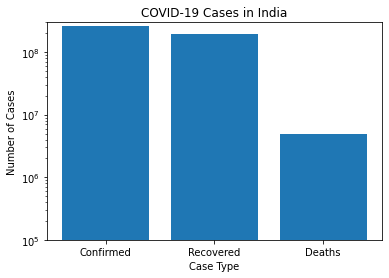

In [0]:
pdf_agg = df_agg.toPandas()
plt.figure(figsize=(6, 4))

plt.bar(['Confirmed', 'Recovered', 'Deaths'], 
        [pdf_agg['sum(Confirmed)'].values[0], 
         pdf_agg['sum(Recovered)'].values[0], 
         pdf_agg['sum(Deaths)'].values[0]])
plt.title('COVID-19 Cases in India')
plt.xlabel('Case Type')
plt.ylabel('Number of Cases')
plt.yscale('log') 
plt.ylim(100000, 300000000) 
plt.show()

In [0]:
# Try exploring the data and see what insights can be drawn from the dataset
print(df.corr("Confirmed", "Recovered"))
print(df.corr("Confirmed", "Deaths"))
print(df.corr("Recovered", "Deaths"))

0.9984272449544407
0.9925951913291563
0.9849329385483047


The correlations suggest that the variables are closely related and might be influenced by similar factors.

The extremely strong correlation between Confirmed cases and Recovered cases implies a consistent recovery rate.

# Data Pre-processing and cleaning

In [0]:

string_columns = ['Date', 'Country']
numeric_columns = ['Confirmed','Recovered','Deaths']
missing_values = {} 
for index, column in enumerate(df.columns):
    if column in string_columns:    
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,Date,Country,Confirmed,Recovered,Deaths
0,0,0,0,0,0


There is no null data in the dataset. No need to handle missing/null data logic.

When working with count data, such as the number of occurrences of a particular event, normalization can be misleading. Count data often follows a Poisson distribution, and normalization can alter the underlying distribution. Therefore,there is no need of normalization or any other feature transformation techniques.

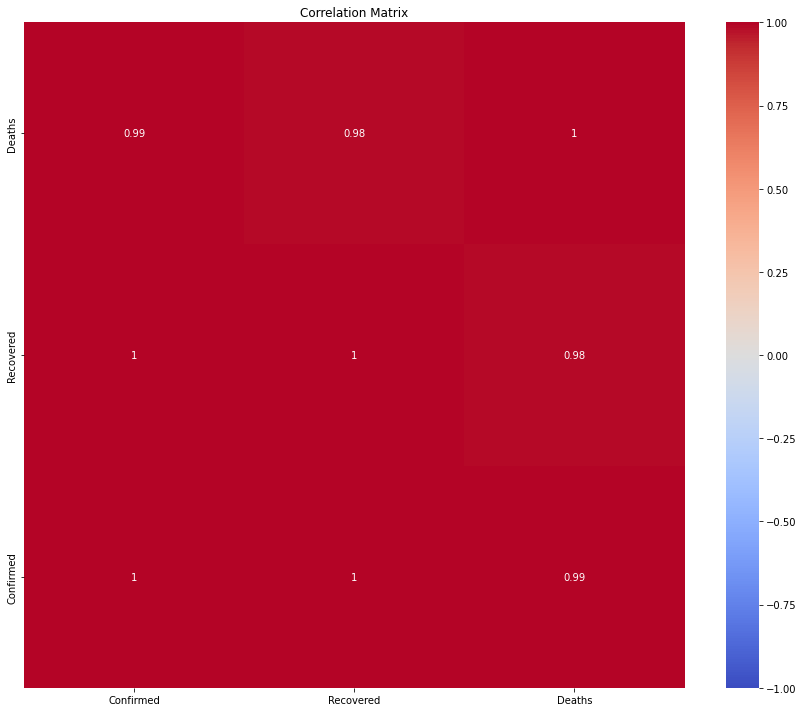

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
pandas_df = df.select(["Confirmed","Recovered","Deaths"]).toPandas()
if pandas_df.empty:
    print("No numeric columns found in the dataset.")
elif pandas_df.shape[1] == 1:
    print("Only one numeric column found. Correlation analysis requires at least two columns.")
else:
    # Remove constant columns
    pandas_df = pandas_df.loc[:, (pandas_df != pandas_df.iloc[0]).any()]
    
    if pandas_df.shape[1] < 2:
        print("After removing constant columns, less than two numeric columns remain. Cannot perform correlation analysis.")
    else:
        # Compute correlation matrix
        correlation_matrix = pandas_df.corr()

        # Plot heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        ax = plt.gca()
        ax.set_xlim(0, correlation_matrix.shape[1])
        ax.set_ylim(0, correlation_matrix.shape[0])
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()

As mentioned above in Data Visualization and Exploration step, the correlations suggest that the variables are closely related and might be influenced by similar factors.                                                     

# Data Preparation

In [0]:
# Convert Date column to date type and extract features
df = df.withColumn("Date", to_date("Date", "dd-MM-yyyy"))
df = df.withColumn("Year", year("Date"))
df = df.withColumn("Month", month("Date"))
df = df.withColumn("Day", dayofmonth("Date"))

# Select features for the model
feature_columns = ["Year", "Month", "Day", "Confirmed", "Recovered"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Prepare the final dataset for modeling
data = df_scaled.select("scaled_features", "Deaths")

# Split the dataset into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Model Building

In [0]:
# Function to train model and print training metrics
def train_and_evaluate(model, train_data, model_name):
    # Train the model
    trained_model = model.fit(train_data)
    
    # Make predictions on training data
    predictions = trained_model.transform(train_data)
    
    # Calculate RMSE
    evaluator_rmse = RegressionEvaluator(labelCol="Deaths", predictionCol="prediction", metricName="rmse")
    rmse = evaluator_rmse.evaluate(predictions)
    
    # Calculate R-squared (coefficient of determination)
    evaluator_r2 = RegressionEvaluator(labelCol="Deaths", predictionCol="prediction", metricName="r2")
    r2 = evaluator_r2.evaluate(predictions)
    
    # Calculate Mean Absolute Error
    evaluator_mae = RegressionEvaluator(labelCol="Deaths", predictionCol="prediction", metricName="mae")
    mae = evaluator_mae.evaluate(predictions)
    
    print(f"\n{model_name} - Training Metrics:")
    print(f"Training Accuracy (R-squared): {r2}")
    print(f"Training Loss (RMSE): {rmse}")
    print(f"Training Loss (MAE): {mae}")
    return trained_model

In [0]:
# Model 1: Linear Regression
lr = LinearRegression(featuresCol="scaled_features", labelCol="Deaths")
lr_model = train_and_evaluate(lr, train_data, "Linear Regression")

# Model 2: Random Forest Regression
rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="Deaths")
rf_model = train_and_evaluate(rf, train_data, "Random Forest")

# Model 3: Gradient Boosted Tree Regression
gbt = GBTRegressor(featuresCol="scaled_features", labelCol="Deaths")
gbt_model = train_and_evaluate(gbt, train_data, "Gradient Boosted Trees")


Linear Regression - Training Metrics:
Training Accuracy (R-squared): 0.9993208498868436
Training Loss (RMSE): 751.2867280011263
Training Loss (MAE): 602.4133463430933

Random Forest - Training Metrics:
Training Accuracy (R-squared): 0.9987431235303845
Training Loss (RMSE): 1022.0429009131374
Training Loss (MAE): 763.0633616265833

Gradient Boosted Trees - Training Metrics:
Training Accuracy (R-squared): 0.9997464701117851
Training Loss (RMSE): 459.0261322993186
Training Loss (MAE): 346.94671654736646


Overall, the Gradient Boosted Trees model appears to be the best performing model based on the training metrics.

# Performance Evaluation

In [0]:
def confusion_matrix(predictions, threshold=100):
    tp = predictions.filter((predictions.Deaths >= threshold) & (predictions.prediction >= threshold)).count()
    tn = predictions.filter((predictions.Deaths < threshold) & (predictions.prediction < threshold)).count()
    fp = predictions.filter((predictions.Deaths < threshold) & (predictions.prediction >= threshold)).count()
    fn = predictions.filter((predictions.Deaths >= threshold) & (predictions.prediction < threshold)).count()
    return pd.DataFrame([[tp, fp], [fn, tn]], columns=['Predicted Positive', 'Predicted Negative'], index=['Actual Positive', 'Actual Negative'])

# Print confusion matrices
print("\nConfusion Matrices (Threshold: 100 deaths)")
print("Linear Regression:")
print(confusion_matrix(lr_predictions))
print("\nRandom Forest:")
print(confusion_matrix(rf_predictions))
print("\nGradient Boosted Trees:")
print(confusion_matrix(gbt_predictions))


Confusion Matrices (Threshold: 100 deaths)
Linear Regression:
                 Predicted Positive  Predicted Negative
Actual Positive                  23                   0
Actual Negative                   1                   0

Random Forest:
                 Predicted Positive  Predicted Negative
Actual Positive                  24                   0
Actual Negative                   0                   0

Gradient Boosted Trees:
                 Predicted Positive  Predicted Negative
Actual Positive                  24                   0
Actual Negative                   0                   0


In [0]:
# Performance Evaluation on Test Data
print("\nTest Data Evaluation:")

def evaluate_on_test(model, test_data, model_name):
    predictions = model.transform(test_data)
    evaluator_rmse = RegressionEvaluator(labelCol="Deaths", predictionCol="prediction", metricName="rmse")
    rmse = evaluator_rmse.evaluate(predictions)

    evaluator_r2 = RegressionEvaluator(labelCol="Deaths", predictionCol="prediction", metricName="r2")
    r2 = evaluator_r2.evaluate(predictions)

    evaluator_mae = RegressionEvaluator(labelCol="Deaths", predictionCol="prediction", metricName="mae")
    mae = evaluator_mae.evaluate(predictions)
    print(f"\n{model_name} - Test Metrics:")
    print(f"Test Accuracy (R-squared): {r2}")
    print(f"Test Loss (RMSE): {rmse}")
    print(f"Test Loss (MAE): {mae}")
    return predictions

lr_predictions = evaluate_on_test(lr_model, test_data, "Linear Regression")
rf_predictions = evaluate_on_test(rf_model, test_data, "Random Forest")
gbt_predictions = evaluate_on_test(gbt_model, test_data, "Gradient Boosted Trees")


Test Data Evaluation:

Linear Regression - Test Metrics:
Test Accuracy (R-squared): 0.9988402809902494
Test Loss (RMSE): 840.6369940196237
Test Loss (MAE): 711.9697481467164

Random Forest - Test Metrics:
Test Accuracy (R-squared): 0.9975851654412683
Test Loss (RMSE): 1213.0418975625073
Test Loss (MAE): 945.1098331843097

Gradient Boosted Trees - Test Metrics:
Test Accuracy (R-squared): 0.9974692306223
Test Loss (RMSE): 1241.8192722887115
Test Loss (MAE): 911.1542635826389


Overall, the Linear Regression model appears to be the best performing model on the test data, followed closely by the Gradient Boosted Trees model. The Random Forest model seems to be the least accurate on the test data.

In [0]:
print("\nLinear Regression Model Predictions:")
lr_predictions.select("Deaths", "prediction").show(10)


Linear Regression Model Predictions:
+------+-------------------+
|Deaths|         prediction|
+------+-------------------+
|  1391|-292.27518937873174|
|  1889|  613.4847861091512|
|  2101|  1056.373670266108|
|  2649|  2201.459510884142|
|  3434|  3644.762218245138|
|  4024|  4735.405003942069|
|  5185|  6326.719602422392|
|  6649|   8002.51356341915|
|  9900| 11183.050302835287|
| 11903| 11504.352626951095|
+------+-------------------+
only showing top 10 rows



**Analysis:**

Gradient Boosted Trees shows signs of overfitting. It performs exceptionally well on the training data but has the highest error on the test data. This suggests that the model has learned the training data too well and doesn't generalize as effectively to new, unseen data.
Linear Regression shows the most consistent performance between training and test data. While it's not the best on the training data, it generalizes well to the test data, suggesting it's captured the underlying trends without overfitting.
Random Forest falls between the other two models. It shows better generalization than Gradient Boosted Trees but doesn't perform as well as Linear Regression on the test data.

**Conclusions:**

If the priority is generalization to new data, Linear Regression appears to be the best choice among these models. It has the lowest test RMSE and shows consistent performance between training and test data.
If the focus is on explaining the relationships between variables, Linear Regression also offers interpretability through its coefficients, which can provide insights into the impact of each feature on the target variable.
The Gradient Boosted Trees model, despite its excellent performance on the training data, may need some regularization or parameter tuning to improve its generalization to new data.
The Random Forest model might benefit from further tuning to improve its performance, as it currently doesn't outperform Linear Regression on either the training or test data.